<a href="https://colab.research.google.com/github/suryateja1638/SURYA-TEJA_INFO5731_FALL2023/blob/main/In_class_exercise_05_04182023_Surya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fifth in-class-exercise (40 points in total, 4/18/2023)**

(20 points) The purpose of the question is to practice different machine learning algorithms for text classification as well as the performance evaluation. In addition, you are requried to conduct *10 fold cross validation (https://scikit-learn.org/stable/modules/cross_validation.html)* in the training.

The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.

Algorithms:

(1) MultinominalNB

(2) SVM

(3) KNN

(4) Decision tree

(5) Random Forest

(6) XGBoost

(7) Word2Vec

(8) BERT

Evaluation measurement:

(1) Accuracy

(2) Recall

(3) Precison

(4) F-1 score

In [ ]:
# Write your code here
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')


def read_data(file_path):
    text_data, sentiments = [], []
    file_data = open(file_path).read()
    for i, j in enumerate(file_data.split("\n")):
        after_split = j.split(' ')
        text_data.append(" ".join(after_split[1:]))
        sentiments.append(after_split[0])
    return text_data, sentiments


def preprocess_data(data_frame):
    # Convert sentiment classes to integers
    data_frame['Sentimental Value'] = pd.to_numeric(data_frame['Sentimental Value'], errors='coerce')

    # Drop rows with NaN values in the target variable
    data_frame = data_frame.dropna(subset=['Sentimental Value'])

    # Pre-processing
    # removal of special characters
    data_frame['After noise removal'] = data_frame['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

    # removal of Punctuation
    data_frame['Punctuation removal'] = data_frame['After noise removal'].str.replace('[^\w\s]', '')

    # Stopwords removal
    stop_word = stopwords.words('english')
    data_frame['Stopwords removal'] = data_frame['Punctuation removal'].apply(
        lambda x: " ".join(word for word in x.split() if word not in stop_word))

    # Lower Casing
    data_frame['Lower casing'] = data_frame['Stopwords removal'].apply(lambda x: " ".join(word.lower() for word in x.split()))

    return data_frame


def vectorize_data(train_df, test_df):
    # TF-IDF Vectorization
    tfidf_vector = TfidfVectorizer(analyzer='word')
    tfidf_vector.fit(train_df['Lower casing'])
    x_train = tfidf_vector.transform(train_df['Lower casing'])
    tfidf_vector_test = TfidfVectorizer(analyzer='word', vocabulary=tfidf_vector.vocabulary_)
    tfidf_vector_test.fit(test_df['Lower casing'])
    x_test = tfidf_vector_test.transform(test_df['Lower casing'])

    return x_train, x_test


def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    accuracy = accuracy_score(predicted, y_test)
    print(f"Accuracy of Training data ({classifier.__class__.__name__}): {accuracy}")

    predicted_testing = classifier.predict(x_test)
    accuracy_testing = accuracy_score(predicted_testing, y_test)
    print(f"Accuracy of Testing data ({classifier.__class__.__name__}): {accuracy_testing}")

    if 'XGB' not in str(classifier):
        scoring = 'accuracy'
        kfold = KFold(10, random_state=7, shuffle=True)
        cross_val = cross_val_score(classifier, x_test, y_test, cv=kfold, scoring=scoring).mean()
        print(f"Cross-validation score ({classifier.__class__.__name__}): {cross_val}")

    print(f"\nClassification Report ({classifier.__class__.__name__}):\n")
    print(classification_report(y_test, predicted))


# Read data
training_text_data, training_sentiments = read_data('stsa-train.txt')
testing_text_data, testing_sentiments = read_data('stsa-test.txt')

# Create data frames
training_df = pd.DataFrame(list(zip(training_sentiments, training_text_data)), columns=['Sentimental Value', 'Raw Data'])
testing_df = pd.DataFrame(list(zip(testing_sentiments, testing_text_data)), columns=['Sentimental Value', 'Raw Data'])

# Pre-process data
training_df = preprocess_data(training_df)
testing_df = preprocess_data(testing_df)

# Vectorize data
x_train, x_test = vectorize_data(training_df, testing_df)

# Split data for training and testing
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, training_df['Sentimental Value'],
                                                                      test_size=0.2, random_state=42)

# Ensure target variables are integers
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

# List of classifiers
classifiers = [
    naive_bayes.MultinomialNB(),
    svm.SVC(),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Evaluate each classifier
for classifier in classifiers:
    print(f"Evaluating {classifier.__class__.__name__}:")
    evaluate_classifier(classifier, x_train, y_train, x_valid, y_valid)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Evaluating MultinomialNB:
Accuracy of Training data (MultinomialNB): 0.7911849710982659
Accuracy of Testing data (MultinomialNB): 0.7911849710982659
Cross-validation score (MultinomialNB): 0.7015848191012408

Classification Report (MultinomialNB):

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       671
           1       0.75      0.89      0.81       713

    accuracy                           0.79      1384
   macro avg       0.80      0.79      0.79      1384
weighted avg       0.80      0.79      0.79      1384

Evaluating SVC:
Accuracy of Training data (SVC): 0.796242774566474
Accuracy of Testing data (SVC): 0.796242774566474
Cross-validation score (SVC): 0.7008758210822645

Classification Report (SVC):

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       671
           1       0.77      0.86      0.81       713

    accuracy                           0.80      1384
   macro 

In [ ]:
pip install gensim sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=2a7bf86d43d6f4d7fdab99a9900bc9e345a99f41e341ed357579c0d08b8f26d5
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


(20 points) The purpose of the question is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K-means

DBSCAN

Hierarchical clustering

Word2Vec

BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [ ]:
# Import libraries
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
nltk.download('wordnet')

# Read data
data_df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
print("Shape: {0}".format(data_df.shape))
cluster_data_df = data_df.head(1000)
cluster_data_df



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape: (413840, 6)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
995,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,It's a decent for the price.. I've had this on...,0.0
996,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,3,Is good cell phone,0.0
997,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,"Amazing phone. Cables and case included, also ...",0.0
998,5.5-Inch Unlocked Lenovo A850 3G Smartphone-(9...,NaN,161.06,5,Excelent,0.0


In [ ]:
# Text preprocessing
cluster_data_df['After noise removal'] = cluster_data_df['Reviews'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', charctr) for charctr in x ))
cluster_data_df['Punctuation removal'] = cluster_data_df['After noise removal'].str.replace('[^\w\s]','')
cluster_data_df['Remove numbers'] = cluster_data_df['Punctuation removal'].str.replace('\d+', '')
stop_word = stopwords.words('english')
cluster_data_df['Stopwords removal'] = cluster_data_df['Remove numbers'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_word))
cluster_data_df['Lower casing'] = cluster_data_df['Stopwords removal'].apply(lambda x: " ".join(x.lower() for x in x.split()))
cluster_data_df['Tokenization'] = cluster_data_df['Lower casing'].apply(lambda x: TextBlob(x).words)
st = PorterStemmer()
cluster_data_df['Stemming'] = cluster_data_df['Tokenization'].apply(lambda x: " ".join([st.stem(word) for word in x]))
cluster_data_df['Lemmatization'] = cluster_data_df['Stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(cluster_data_df['Lemmatization'].values)

# K-Means Clustering
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters=10, random_state=99)
model_tf.fit(tfidf)
labels_tf = model_tf.labels_
cluster_center_tf = model_tf.cluster_centers_
terms1 = tfidf_vect.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
silhouette_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')


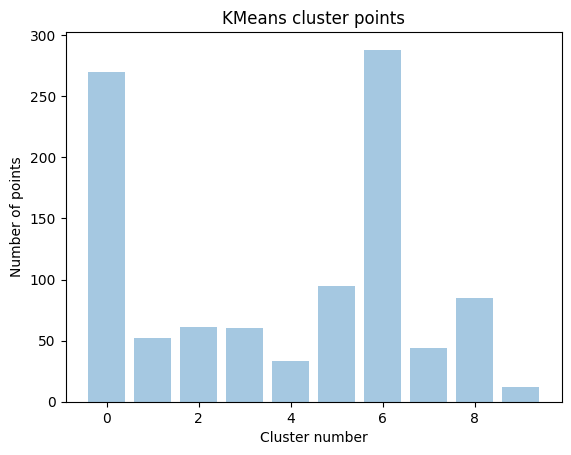

4 reviews assigned to cluster 0
----------------------------------------------------------------------
Very pleased


as described, fast ship!


Very practical and user-friendly phone. I am very satisfied with it.


______________________________________________________________________
4 reviews assigned to cluster 1
----------------------------------------------------------------------
excellent product in perfect condition


Excellent phone has all the special functions to be communicated with all social networks, excellent operational...I recommend it 100% excellent product


Excelent


______________________________________________________________________
4 reviews assigned to cluster 2
----------------------------------------------------------------------
My fiance had this phone previously, but caused many problems. So, of course, we decided to browse amazon for a replacement til' our contract is up! & so far so good!


perfect, practical, easy to handle, good resolution, well pa

In [ ]:
# Visualization
import matplotlib.pyplot as plt
plt.bar([x for x in range(10)], df1.groupby(['Tfidf Clus Label'])['Reviews'].count(), alpha=0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

# Reading reviews by cluster
for i in range(10):
    print(f"4 reviews assigned to cluster {i}")
    print("-" * 70)
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][0]]['Reviews'])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][5]]['Reviews'])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][10]]['Reviews'])
    print('\n')
    print("_" * 70)


In [ ]:
# K-means - Method 2
# Generating bag of words features.
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(cluster_data_df['Reviews'].values)
bow.shape

from sklearn.cluster import KMeans
model = KMeans(n_clusters=10, init='k-means++', random_state=99)
model.fit(bow)
labels = model.labels_
cluster_center = model.cluster_centers_

from sklearn import metrics
print(metrics.silhouette_score(bow, labels, metric='euclidean'))

cluster_data_df['Bow Clus Label'] = model.labels_  # the last column you can see the label numbers
cluster_data_df.head(2)


0.39528026327024723


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,After noise removal,Punctuation removal,Remove numbers,Stopwords removal,Lower casing,Tokenization,Stemming,Lemmatization,Bow Clus Label,AVG-W2V Clus Label
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel so LUCKY to have found this used phone...,I feel LUCKY found used phone us used hard pho...,i feel lucky found used phone us used hard pho...,"[i, feel, lucky, found, used, phone, us, used,...",i feel lucki found use phone us use hard phone...,i feel lucki found use phone u use hard phone ...,9,0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice up grade from my pantach revu...,nice phone nice grade pantach revue Very clean...,nice phone nice grade pantach revue very clean...,"[nice, phone, nice, grade, pantach, revue, ver...",nice phone nice grade pantach revu veri clean ...,nice phone nice grade pantach revu veri clean ...,0,0


The two reviews assigned to cluster  0
----------------------------------------------------------------------
I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!


nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung


______________________________________________________________________
The two reviews assigned to cluster  1
----------------------------------------------------------------------
100% gooddd!


fino fino


______________________________________________________________________
The two reviews a

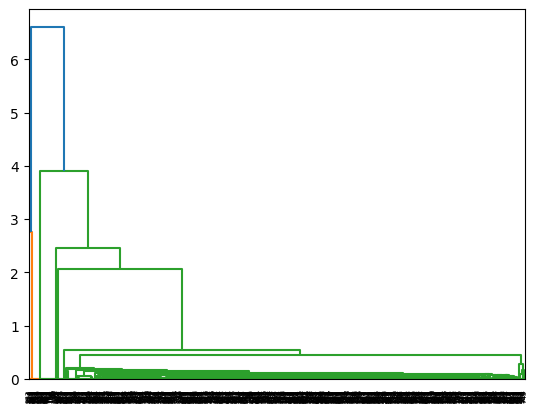

In [ ]:
# DBSCAN clustering
from sklearn.cluster import DBSCAN
import numpy as np
minPts = 2 * 100
def lower_bound(nums, target):
    l, r = 0, len(nums) - 1
    while l <= r:
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data):
    dists = []
    for val in data:
        dist = np.sum((x - val) ** 2)
        if len(dists) == 200 and dists[199] > dist:
            l = int(lower_bound(dists, dist))
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()

    return dists[199]

list_of_trains_sent = list()
for i in cluster_data_df["Lower casing"].values:
    list_of_trains_sent.append(i.split())

import gensim
w2v_model = gensim.models.Word2Vec(list_of_trains_sent, vector_size=100, workers=4)


from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize


list_of_sent_train = cluster_data_df['Lower casing'].apply(lambda x: x.split())
sent_vectors = []

for sent in list_of_sent_train:
    sent_vec = np.zeros(100)
    cnt_words = 1
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)
sent_vectors = normalize(sent_vectors)

# Computing the 200th nearest neighbour distance of some point in the dataset:
twohundredthneighbour = []
for val in sent_vectors[:300]:
    twohundredthneighbour.append(compute200thnearestneighbour(val, sent_vectors[:300]))

twohundredthneighbour.sort()

# Training DBSCAN:
model_dbscan = DBSCAN(eps=5, min_samples=minPts, n_jobs=-1)
model_dbscan.fit(sent_vectors)
cluster_data_df['AVG-W2V Clus Label'] = model_dbscan.labels_
cluster_data_df.head(2)

# Hierarchical Clustering
import scipy
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

dendro = hierarchy.dendrogram(hierarchy.linkage(sent_vectors, method='ward'))
plt.axhline(y=10)  # cut at 30 to get 5 clusters

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg = cluster.fit_predict(sent_vectors)

# Giving Labels/assigning a cluster to each point/text
aggdfa = cluster_data_df
aggdfa['AVG-W2V Clus Label'] = cluster.labels_

# Count of points belonging to each cluster
aggdfa.groupby(['AVG-W2V Clus Label'])['Reviews'].count()

# Reading a review which belong to each group
for i in range(5):
    print("The two reviews assigned to cluster ", i)
    print("-" * 70)
    for j in [0, 1]:
        print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][j]]['Reviews'])
        print('\n')
    print("_" * 70)


In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.

The k-means algorithm is designed for partitioning extensive datasets into predefined clusters, accommodating various cluster shapes and sizes. Its efficiency is particularly notable in handling large datasets. On the other hand, DBSCAN is tailored for identifying clusters of varying density, making it adept at handling noisy data, although its scalability may be a limitation when dealing with massive datasets. Hierarchical Clustering, primarily utilized for categorizing grouped objects, encounters challenges in accurately defining clusters and may not be the optimal choice for clusters with complex, hyper-spherical shapes.